In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('/home/mz1482/project/vt-bayesian-opt-bopt_debug/my_bayes_opt/')
import bo_new
import math
from numpy.linalg import multi_dot
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from data_analysis import get_heart_bounds, correlation_coef, graph_3d
from graph import narrow,corrplot3axes,trend,nearest,plot_exploration, graph_dist_over_axis, graph_cc_distribution, cube
# from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
# from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
matplotlib.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer
from prettytable import PrettyTable
from scipy.stats import wasserstein_distance

In [2]:
def get_index(label):
    """
    Gets the idx of a label in the labels array
    :param label: label to check for
    :return: idx
    """
    idx = 0
    for coord in labels:
        if np.array_equal(label, coord):
            break
        idx += 1
    return idx

def black_box(x, y, z):
    """
    Represents a black box function to maximize for CC of two ECGs given an XYZ coordinate
    :param x:
    :param y: coordinates of the prediction
    :param z:
    :return: CC of that point and the target
    """
    sample_ecg = ecgs[get_index(np.array([x, y, z]))]
    return correlation_coef(target_ecg, sample_ecg)

def optimize_point(labels,bounds):
    # Build the optimizer with the heart bounds
    optimizer = bo_new.mybo(
        f=black_box,
        pbounds=bounds, real_set=labels
    )

    # Maximize over x number of points
    optimizer.maximize(init_points=10, n_iter=15,  acq="ucb", kappa = 2)
    return optimizer


In [3]:
ecgs = pd.read_csv("/home/mz1482/project/vt-bayesian-opt-bopt_debug/simu-data/Heart3_SimuData.csv", header=None).to_numpy()
labels = pd.read_csv("/home/mz1482/project/vt-bayesian-opt-bopt_debug/simu-data/Heart3_XYZsub.csv", header=None).to_numpy() / 1000
# Get bounds of the heart mesh
bounds = get_heart_bounds(labels)
# Pick out a sample to use as a target
tidx = np.random.randint(0, labels.shape[0])
target, target_ecg = labels[tidx], ecgs[tidx]

In [4]:
optimizer = bo_new.mybo(f=black_box,pbounds=bounds, real_set=labels)
gp = optimizer.maximize(init_points=10, n_iter=15,  acq="ucb", kappa = 2)

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |         x |         y |         z | 
    1 | 00m00s |    0.32748 |   51.9616 |  -88.9142 |  -21.3557 | 
    2 | 00m00s |    0.19723 |   16.9412 |  -41.9486 |  -64.8507 | 
    3 | 00m00s |    0.82982 |   40.6245 |  -86.7603 |  -79.6754 | 
    4 | 00m00s |    0.56187 |   79.0456 | -101.0466 |  -80.9411 | 
    5 | 00m00s |    0.03403 |    5.4939 |  -56.2252 |   -5.2393 | 
    6 | 00m00s |    0.78611 |   38.0502 |  -87.5854 |  -75.1105 | 
    7 | 00m00s |    0.49528 |   14.9734 |  -63.5940 |  -62.0726 | 
    8 | 00m00s |    0.25922 |   18.5915 |  -55.9239 |  -68.6394 | 
    9 | 00m00s |    0.87264 |   60.5364 |  -82.3119 |  -82.7600 | 
   10 | 00m00s |    0.69487 |   53.5073 | -101.2240 |  -55.6180 | 
Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |         x |         y |         z | 
   11 | 00m02s |    0.50025

In [25]:
from matplotlib import cm
def gp_plot(gp):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X = np.arange(-118, 94, 0.25)
    Y = np.arange(-118, 94, 0.25)
    Z = np.arange(-118, 94, 0.25)
    R = np.array([X,Y,Z]).T
    G = gp.predict(R,return_std=False).reshape(len(X),1)
    surf = ax.plot_surface(X, Y, G, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#     plt.plot(X,G)
#     plt.scatter(Y,G)
#     plt.scatter(Z,G)
    plt.show()

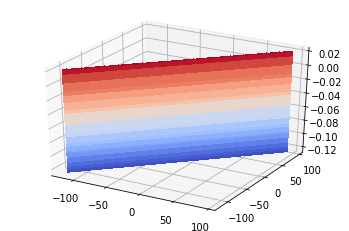

In [26]:
gp_plot(gp)

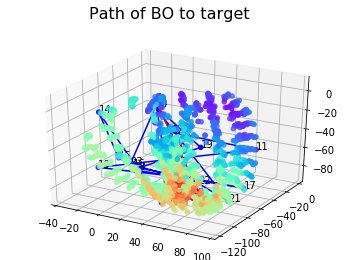

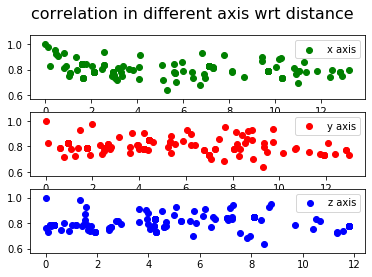

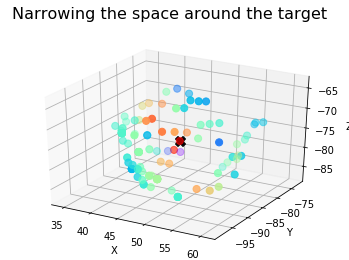

In [5]:
color_gradient = []
# Loop through all points to get CC with that point
for ecg, coord in zip(ecgs, labels):
    if np.array_equal(target_ecg, ecg):
        true = coord
        color_gradient.append(1)
        continue

    cc = correlation_coef(target_ecg, ecg)
    color_gradient.append(cc)

plot_exploration(target,labels,optimizer.X, color_gradient)

#     graph_cc_distribution(target_ecg,ecgs,labels)
x,y,z,nn_cc = corrplot3axes(tidx,labels,ecgs,15)
narrow(target,target_ecg,ecgs,labels,15)

In [6]:
y_init = []
keys = list(bounds.keys())
idx= np.random.choice(len(labels), size=5, replace=False)
init_points = labels[idx,:]
for x in init_points:
    y_init.append(black_box(**dict(zip(keys, x))))
x

array([  85.8618125 , -103.48588281,  -78.13085156])

In [7]:
optimizer.X[5:len(optimizer.X),:]

array([[  38.05016797,  -87.58542969,  -75.11045313],
       [  14.97335645,  -63.59397656,  -62.07259766],
       [  18.59151953,  -55.92386328,  -68.6394375 ],
       [  60.53641016,  -82.311875  ,  -82.75996094],
       [  53.50732422, -101.22395312,  -55.61803516],
       [ -10.07483008, -111.63642187,  -55.97594531],
       [  81.43164844,  -31.52912109,  -51.34496484],
       [  -1.12622742,  -23.8564668 ,  -53.67905078],
       [  40.96883984, -102.91609375,  -85.712     ],
       [ -21.07585156,  -93.0223125 ,   -8.65564063],
       [ -19.42402539,  -71.1575625 ,  -65.73139844],
       [  -3.0566189 ,  -75.84803125,  -69.5246875 ],
       [  92.70408594,  -68.49539844,  -73.49510156],
       [  -3.7619773 ,  -74.02358594,  -73.67380469],
       [  68.895125  ,  -92.13367969,  -25.87423633],
       [   2.65679565,  -56.38146094,   -9.05457031],
       [  89.86682031,  -86.35464844,  -79.72271094],
       [  76.00507812, -106.44375781,  -55.01658984],
       [  -9.2188125 ,  -70.

In [8]:
bo = bo_new.mybo(obj_function, {'x': (boundx[0], boundx[1])})
# bo = bo_new.mybo(obj_function, {'x': (boundx[0], boundx[1]),'y':(boundy[0], boundy[1])})
# x,y,k,gp = bo.maximize(init_points=5, n_iter=2, acq=af_gp,kappa=3.29)

NameError: name 'obj_function' is not defined

In [ ]:
# gp= bo.gpfit(init_points=5, n_iter=5, acq=af_gp,kappa=3.29)
bo.maximize(init_points=5, n_iter=2, acq=af_gp,kappa=3.29)
# gp= bo.gpfit2(init_points=5, n_iter=5, acq=af_exp_gp,kappa=3.29)

In [ ]:
mcmc_chain = 2
z1_new = []
# z2_new = []
chain = []
samples = []
for c in range(mcmc_chain):
    zfix = np.random.normal(loc = 0, scale = .1,size=1)
    x_0=np.reshape(zfix,(1,1))
    param = gp.predict(x_0, return_std= True)
    m=param[0].ravel() # mean of gp
    v=param[1].ravel() # sigma of gp
#     log_mean_0 = np.exp(m+v**2/2)
    for j in range(10000):      
        z_star = zfix + np.random.normal(loc = 0, scale = .2,size=1)
        z_star2 = np.reshape(z_star,(1,1))
        param2 = gp.predict(z_star2, return_std= True)
        m2=param2[0].ravel() # mean of gp
        v2=param2[1].ravel() # sigma of gp
#         log_mean_2 = np.exp(m2+v2**2/2)
        if (-4<z_star[0]<4):
            rho = min(1, np.exp(m2)/np.exp(m))
            r=np.random.rand()
            if r < rho:
#                 f= open("/home/mz1482/project/my_work/case3_ant_1_sample_exp(gp)_entropy.txt","a")
#                 f.write(str(c) + "," + str(z_star[0]) + "," + str(z_star[1]) + "," + str(log_mean_2[0]) +"\n")
#                 f.close()
                zfix = z_star
#                 log_mean_0 = log_mean_2
                z1_new = np.append(z1_new,z_star[0])
#                 z2_new = np.append(z2_new,z_star[1])
                chain = np.append(chain,c)
samples = np.vstack([chain,z1_new])
ar=len(z1_new)/(mcmc_chain*10000)
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from GP")
ax1.plot(x_actual, stats.norm.pdf(x_actual, mu, sigma),color='red',label = "True pdf")
ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
# sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
# ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
plt.show()         

In [ ]:
ar

In [ ]:
x_new = samples[1]
#calculate kl divergence
m1 = 0
m2 = np.mean(x_new)
s1 = .1
s2 = np.std(x_new)
d = kl(m1,m2,s1,s2)
print(m2)
print(s2)
print(d)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from exp(GP)")
ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
# sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
# ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
plt.show()      

In [ ]:
break

In [ ]:
# data = bo.gp_shape(init_points=5, n_iter=10, acq=af_gp,kappa=3.29,mh_size = 1000)
# z1= data[:,0]
# z2 = data[:,1]
# fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="pdf")

In [ ]:
#mcmc from exact function
def mh(iteration,boundx,boundy,mcmc_chain,fn):
    ux=np.random.uniform(boundx[0],boundx[1])
    uy=np.random.uniform(boundy[0],boundy[1])
    z1_new = []
    z2_new = []
    chain = []
    t1=time.time()
    for c in range(mcmc_chain):
        zfix = np.random.normal(loc = 0, scale = .1,size=2)
        a=fn(zfix[0],zfix[1])
        for i in range(iteration):
            z_star = zfix + np.random.normal(loc = 0, scale = 0.8,size=2)
            if (boundx[0]<z_star[0]<boundx[1]) and (boundy[0]<z_star[1]<boundy[1]):
                r=np.random.rand()
                b=fn(z_star[0],z_star[1])  
                rho = min(1, b/a)
                if r < rho:
                    zfix = z_star
                    a = b
                    z1_new = np.append(z1_new,z_star[0])
                    z2_new = np.append(z2_new,z_star[1])
                    chain = np.append(chain,c)
    t2=time.time()
    samples = np.vstack([chain,z1_new,z2_new])
    print((t2-t1)/3600)
    return samples.T
data = mh(10000,boundx,boundy,2,target2)
z1= data[:,1]
z2 = data[:,2]
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
sns.kdeplot(z1, ax=ax1,color="red",label="pdf")
sns.kdeplot(z2, ax=ax2,color="red",label="pdf")

In [ ]:
b.shape

In [ ]:
pbounds = {'x': (boundx[0], boundx[1]),'y':(boundy[0], boundy[1])}
keys = list(pbounds.keys())
#no of parameters
dim = len(pbounds)
# Create an array with parameters bounds
bounds = []
for key in pbounds.keys():
    bounds.append(pbounds[key])
bounds = np.asarray(bounds)
dim_limit=bounds

In [ ]:
mcmc_chain = 2
z_sample = np.empty((0,dim))
for c in range(mcmc_chain):
    ux=np.zeros(dim)
    for k in range(dim):
        ux[k]= np.random.uniform(dim_limit[k,0],dim_limit[k,1])
    zfix = ux
    x_0=np.reshape(zfix,(1,-1))
    param = gp.predict(x_0, return_std= True)
    m=param[0].ravel() # mean of gp
    v=param[1].ravel() # sigma of gp
    log_mean_0 = np.exp(m+v**2/2)
    for j in range(10000):
        z_star = zfix + np.random.normal(loc = 0, scale = .5,size=dim)
        z_star2 = np.reshape(z_star,(1,-1))
        inside = 0
        for pp in range(dim):
            if (dim_limit[pp,0]<z_star[pp]<dim_limit[pp,1]):
                inside = inside + 1
        if inside == dim:
            param2 = gp.predict(z_star2, return_std= True)
            m2=param2[0].ravel() # mean of gp
            v2=param2[1].ravel() # sigma of gp
            log_mean_2 = np.exp(m2+v2**2/2)
            rho = min(1, log_mean_2/log_mean_0)
            r=np.random.rand()
            if r < rho:
                zfix = z_star
                log_mean_0 = log_mean_2
                z_sample = np.append(z_sample,z_star2,axis=0)

In [ ]:
data = z_sample
z1= data[:,0]
z2 = data[:,1]
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
sns.kdeplot(z1, ax=ax1,color="red",label="pdf")
sns.kdeplot(z2, ax=ax2,color="red",label="pdf")

In [ ]:
gp

In [ ]:
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [ ]:
# Sample from the Gaussian process distribution
nb_of_samples = 3  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
cov = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=cov, 
    size=number_of_functions)

In [ ]:
bounds=np.array([[-4,4],[-4,4]])
x_tries = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(10, bounds.shape[0]))

In [ ]:
#mcmc from GP
mcmc_chain = 2
z1_new = []
# z2_new = []
chain = []
samples = []
for c in range(mcmc_chain):
    zfix = np.random.normal(loc = 0, scale = 1,size=1)
    x_0=np.reshape(zfix,(1,1))
    param = gp.predict(x_0, return_std= True)
    m=param[0].ravel() # mean of gp
    v=param[1].ravel() # sigma of gp
#     log_mean_0 = np.exp(m+v**2/2)
    for j in range(10000):      
        z_star = zfix + np.random.normal(loc = 0, scale = 2,size=1)
        z_star2 = np.reshape(z_star,(1,1))
        param2 = gp.predict(z_star2, return_std= True)
        m2=param2[0].ravel() # mean of gp
        v2=param2[1].ravel() # sigma of gp
#         log_mean_2 = np.exp(m2+v2**2/2)
        if (-4<z_star[0]<4):
            rho = min(1, np.exp(m2)/np.exp(m))
            r=np.random.rand()
            if r < rho:
#                 f= open("/home/mz1482/project/my_work/case3_ant_1_sample_exp(gp)_entropy.txt","a")
#                 f.write(str(c) + "," + str(z_star[0]) + "," + str(z_star[1]) + "," + str(log_mean_2[0]) +"\n")
#                 f.close()
                zfix = z_star
#                 log_mean_0 = log_mean_2
                z1_new = np.append(z1_new,z_star[0])
#                 z2_new = np.append(z2_new,z_star[1])
                chain = np.append(chain,c)
samples = np.vstack([chain,z1_new])
ar=len(z1_new)/(mcmc_chain*10000)
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,10))
# sns.kdeplot(z1, ax=ax1,color="red",label="True pdf")
sns.kdeplot(z1_new, ax=ax1,color="green",label="pdf from exp(GP)")
ax1.set(xlabel="dimension 1 = z1", ylabel = "pdf")
# sns.kdeplot(z2, ax=ax2,color="red",label="True pdf")
# sns.kdeplot(z2_new, ax=ax2,color="green",label="pdf from exp(GP)")
# ax2.set(xlabel="dimension 2 = z2", ylabel = "pdf")
plt.show()

In [ ]:
ar

In [ ]:
from scipy.optimize import minimize
def rosen(x):

    """The Rosenbrock function"""

    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


In [ ]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

In [ ]:
x= np.linspace(-4,4,10000)
y = gp.predict(x, return_std= False)
y=np.exp(y)
# y = obj_function(x)
plt.plot(x,y)
plt.show()

In [ ]:
rs = np.random.multivariate_normal(np.zeros(1), 1.0/10*np.diag(np.ones(1)),10)

In [ ]:
np.random.uniform(low=-4, high=4, size=(10,2))

In [ ]:
import lammps